In [1]:
# %% [markdown]
# # Cell 1: Đọc và xử lý dữ liệu, xử lý NaN trong cột Vol.

# %%
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

TRAIN_FILE = "../../../Dataset/Splits/train_70_15_15.csv"
VAL_FILE   = "../../../Dataset/Splits/val_70_15_15.csv"
TEST_FILE  = "../../../Dataset/Splits/test_70_15_15.csv"

train_df = pd.read_csv(TRAIN_FILE, parse_dates=["Date"])
val_df = pd.read_csv(VAL_FILE, parse_dates=["Date"])
test_df = pd.read_csv(TEST_FILE, parse_dates=["Date"])

def parse_value(x):
    if isinstance(x, str):
        s = x.replace('$','').replace(',','')
        if s.endswith('%'): return float(s[:-1])
        if s.endswith('K'): return float(s[:-1]) * 1e3
        if s.endswith('M'): return float(s[:-1]) * 1e6
        return float(s)
    return x

def clean_df(df):
    df = df.copy()
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].apply(parse_value)
    return df

train_df = clean_df(train_df)
val_df = clean_df(val_df)
test_df = clean_df(test_df)

# Gộp dữ liệu
df_all = pd.concat([train_df, val_df, test_df]).sort_values("Date").reset_index(drop=True)

# Thay NaN trong cột Vol. bằng giá trị trung bình
vol_mean = df_all['Vol.'].mean()
df_all['Vol.'].fillna(vol_mean, inplace=True)

# Thêm các đặc trưng thời gian & kỹ thuật
df_all["day_of_week"] = df_all["Date"].dt.dayofweek
df_all["month"] = df_all["Date"].dt.month
df_all["rolling_mean_5"] = df_all["Price"].rolling(window=5).mean()
df_all["rolling_std_5"] = df_all["Price"].rolling(window=5).std()
df_all["return_1d"] = df_all["Price"].pct_change()

# Kiểm tra số lượng NaN
nan_counts = df_all.isna().sum()
print("Số lượng giá trị NaN từng cột sau xử lý Vol.:")
print(nan_counts)

# Drop NaN còn lại do rolling và pct_change tạo ra
df_all.dropna(inplace=True)

feature_cols = ["Price", "Open", "High", "Low", "Vol.", "Change %", "CPIAUCSL",
                "day_of_week", "month", "rolling_mean_5", "rolling_std_5", "return_1d"]

scaler = StandardScaler()
df_all[feature_cols] = scaler.fit_transform(df_all[feature_cols])


Số lượng giá trị NaN từng cột sau xử lý Vol.:
Date              0
Price             0
Open              0
High              0
Low               0
Vol.              0
Change %          0
CPIAUCSL          0
day_of_week       0
month             0
rolling_mean_5    4
rolling_std_5     4
return_1d         1
dtype: int64


C:\Users\quyen\AppData\Local\Temp\ipykernel_17848\2652858496.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_all['Vol.'].fillna(vol_mean, inplace=True)


In [2]:
# %% [markdown]
# # Cell 2: Chuẩn bị dữ liệu chuỗi (lagged)

# %%
SEQ_LEN = 90

def create_multivariate_lagged(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, :])
        y.append(data[i, 0])  # target là Price
    return np.array(X), np.array(y)

X_all, y_all = create_multivariate_lagged(df_all[feature_cols].values, SEQ_LEN)

n_train = len(train_df) - SEQ_LEN
n_val = len(val_df)

X_train = X_all[:n_train]
X_val = X_all[n_train:n_train+n_val]
X_test = X_all[n_train+n_val:]

y_train = y_all[:n_train]
y_val = y_all[n_train:n_train+n_val]
y_test = y_all[n_train+n_val:]


In [3]:
# %% [markdown]
# # Cell 3: Tạo DataLoader PyTorch

# %%
import torch
from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
), batch_size=32, shuffle=False)

val_loader = DataLoader(TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32)
), batch_size=32)

test_loader = DataLoader(TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32)
), batch_size=32)


In [4]:
# %% [markdown]
# # Cell 4: Định nghĩa mô hình WaveNet

# %%
import torch.nn as nn

class WaveNetBlock(nn.Module):
    def __init__(self, dilation, in_ch, out_ch, kernel_size=2):
        super().__init__()
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size, dilation=dilation, padding='same')
        self.relu = nn.ReLU()
        self.skip = nn.Conv1d(out_ch, in_ch, kernel_size=1)

    def forward(self, x):
        out = self.relu(self.conv(x))
        skip = self.skip(out)
        if skip.size(2) != x.size(2):
            min_len = min(skip.size(2), x.size(2))
            x = x[:, :, :min_len]
            skip = skip[:, :, :min_len]
        return x + skip, skip

class WaveNet(nn.Module):
    def __init__(self, in_ch, out_ch=32, dilations=[1, 2, 4, 8]):
        super().__init__()
        self.blocks = nn.ModuleList([
            WaveNetBlock(d, in_ch, out_ch) for d in dilations
        ])
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(in_ch, 1)

    def forward(self, x):
        x = x.transpose(1, 2)  # B, C, T
        skip_total = None
        for block in self.blocks:
            x, skip = block(x)
            skip_total = skip if skip_total is None else skip_total + skip
        x = self.dropout(skip_total)
        x = x.mean(dim=2)  # Global average pooling
        return self.fc(x).squeeze(1)


In [5]:
# %% [markdown]
# # Cell 5: Khởi tạo model, optimizer, loss

# %%
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WaveNet(in_ch=X_train.shape[2]).to(device)

import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [6]:
# %% [markdown]
# # Cell 6: Huấn luyện model

# %%
from tqdm import tqdm

EPOCHS = 100
best_val_loss = float("inf")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_wavenet.pt")


c:\Users\quyen\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.conv1d(


Epoch 01 | Train Loss: 0.4957 | Val Loss: 0.3280
Epoch 02 | Train Loss: 0.1742 | Val Loss: 0.2937
Epoch 03 | Train Loss: 0.0902 | Val Loss: 0.1813
Epoch 04 | Train Loss: 0.0651 | Val Loss: 0.1012
Epoch 05 | Train Loss: 0.0535 | Val Loss: 0.0634
Epoch 06 | Train Loss: 0.0483 | Val Loss: 0.0473
Epoch 07 | Train Loss: 0.0463 | Val Loss: 0.0403
Epoch 08 | Train Loss: 0.0446 | Val Loss: 0.0367
Epoch 09 | Train Loss: 0.0433 | Val Loss: 0.0343
Epoch 10 | Train Loss: 0.0419 | Val Loss: 0.0326
Epoch 11 | Train Loss: 0.0402 | Val Loss: 0.0311
Epoch 12 | Train Loss: 0.0390 | Val Loss: 0.0300
Epoch 13 | Train Loss: 0.0381 | Val Loss: 0.0291
Epoch 14 | Train Loss: 0.0369 | Val Loss: 0.0284
Epoch 15 | Train Loss: 0.0354 | Val Loss: 0.0280
Epoch 16 | Train Loss: 0.0346 | Val Loss: 0.0276
Epoch 17 | Train Loss: 0.0331 | Val Loss: 0.0273
Epoch 18 | Train Loss: 0.0319 | Val Loss: 0.0271
Epoch 19 | Train Loss: 0.0310 | Val Loss: 0.0271
Epoch 20 | Train Loss: 0.0297 | Val Loss: 0.0271
Epoch 21 | Train Los

In [7]:
# %% [markdown]
# # Cell 7: Đánh giá model trên test set

# %%
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model.load_state_dict(torch.load("best_wavenet.pt"))
model.eval()

y_preds = []
y_trues = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch).cpu().numpy()
        y_preds.extend(y_pred)
        y_trues.extend(y_batch.numpy())

y_preds = np.array(y_preds)
y_trues = np.array(y_trues)

mae = mean_absolute_error(y_trues, y_preds)
rmse = mean_squared_error(y_trues, y_preds)
mape = np.mean(np.abs((y_trues - y_preds) / y_trues)) * 100
r2 = r2_score(y_trues, y_preds)
n = len(y_trues)
p = X_train.shape[2]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"MAE       : {mae:.4f}")
print(f"RMSE      : {rmse:.4f}")
print(f"MAPE      : {mape:.2f}%")
print(f"R²        : {r2:.4f}")
print(f"Adj R²    : {adj_r2:.4f}")


MAE       : 0.1349
RMSE      : 0.0299
MAPE      : 8.32%
R²        : 0.9625
Adj R²    : 0.9618


In [8]:
# %% [markdown]
# # Cell 8: Dự báo 90 ngày tương lai

# %%
model.eval()
input_seq = torch.tensor(X_test[-1:], dtype=torch.float32).to(device)

forecast_scaled = []

with torch.no_grad():
    for _ in range(90):
        y_next = model(input_seq).cpu().item()
        forecast_scaled.append(y_next)

        new_input = input_seq[:, 1:, :].clone()
        new_step = new_input[:, -1:, :].clone()
        new_step[:, :, 0] = y_next
        input_seq = torch.cat([new_input, new_step], dim=1)

forecast = np.array(forecast_scaled) * scaler.scale_[0] + scaler.mean_[0]


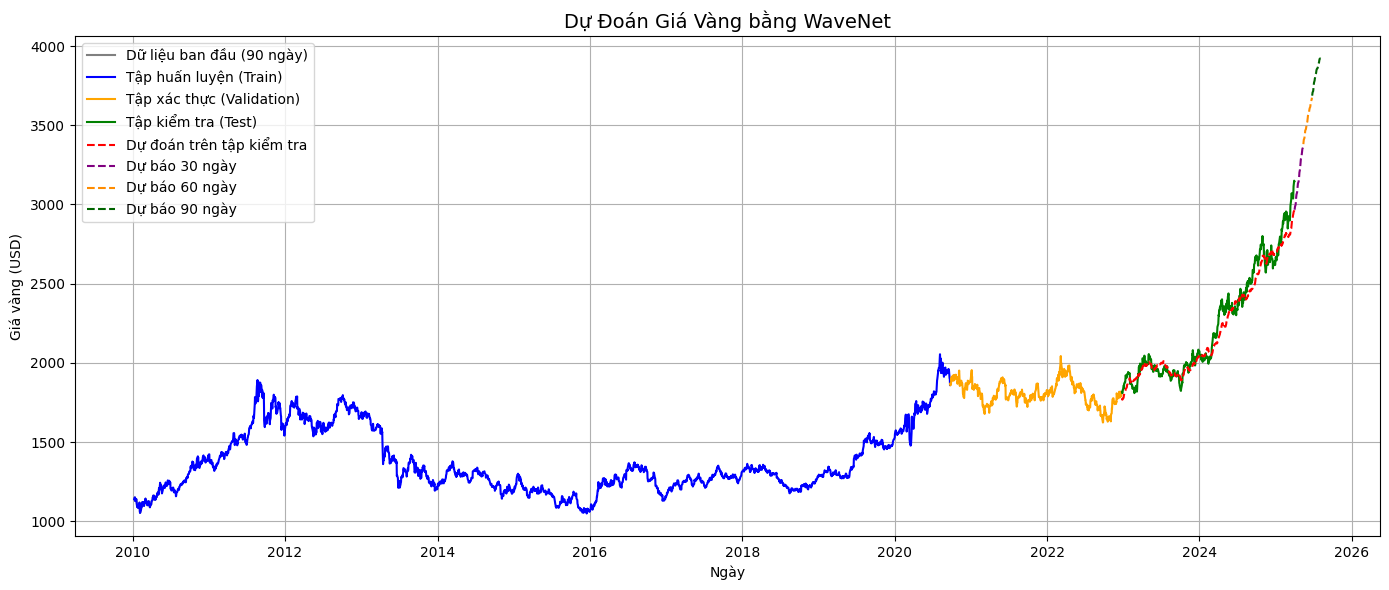

In [9]:
# %% [markdown]
# # Cell 9: Vẽ kết quả dự báo

# %%
import matplotlib.pyplot as plt
import numpy as np
from pandas.tseries.offsets import BDay

target_col = "Price"

train_len = len(train_df)
val_len = len(val_df)
start_idx = train_len + val_len

test_dates = df_all['Date'].iloc[start_idx:start_idx + len(y_trues)].reset_index(drop=True)

y_trues_rescaled = y_trues * scaler.scale_[0] + scaler.mean_[0]
y_preds_rescaled = y_preds * scaler.scale_[0] + scaler.mean_[0]

plt.figure(figsize=(14, 6))

plt.plot(df_all['Date'][:90], df_all[target_col].values[:90]*scaler.scale_[0] + scaler.mean_[0], color='gray', label='Dữ liệu ban đầu (90 ngày)')
plt.plot(df_all['Date'][:train_len], df_all[target_col].values[:train_len]*scaler.scale_[0] + scaler.mean_[0], color='blue', label='Tập huấn luyện (Train)')
plt.plot(df_all['Date'][train_len:train_len+val_len], df_all[target_col].values[train_len:train_len+val_len]*scaler.scale_[0] + scaler.mean_[0], color='orange', label='Tập xác thực (Validation)')
plt.plot(df_all['Date'][start_idx:], df_all[target_col].values[start_idx:]*scaler.scale_[0] + scaler.mean_[0], color='green', label='Tập kiểm tra (Test)')

plt.plot(test_dates, y_preds_rescaled, color='red', linestyle='--', label='Dự đoán trên tập kiểm tra')

try:
    last_test_date = pd.to_datetime(test_dates.iloc[-1])
    full_forecast = np.concatenate([y_preds_rescaled[-1:], forecast])
    full_dates = pd.date_range(last_test_date, periods=len(full_forecast), freq=BDay())

    plt.plot(full_dates[1:31], full_forecast[1:31], color='purple', linestyle='--', label='Dự báo 30 ngày')
    plt.plot(full_dates[31:61], full_forecast[31:61], color='darkorange', linestyle='--', label='Dự báo 60 ngày')
    plt.plot(full_dates[61:], full_forecast[61:], color='darkgreen', linestyle='--', label='Dự báo 90 ngày')
except NameError:
    pass

plt.title("Dự Đoán Giá Vàng bằng WaveNet", fontsize=14)
plt.xlabel("Ngày")
plt.ylabel("Giá vàng (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
!jupyter nbconvert --to html WaveNet_70-15-15.ipynb

[NbConvertApp] Converting notebook WaveNet_70-15-15.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 443456 bytes to WaveNet_70-15-15.html
